In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [83]:
df_pip = pd.read_csv('dataset\pip.csv')
df_le = pd.read_csv('dataset\life-expectancy.csv')

In [79]:
# Create a dataframe that links country to region
df_region_country = df_pip[['region_name','region_code','country_name','country_code']].drop_duplicates()
df_region_country

,region_name,region_code,country_name,country_code
0,Sub-Saharan Africa,SSA,Angola,AGO
3,Europe & Central Asia,ECA,Albania,ALB
17,Other High Income Countries,OHI,United Arab Emirates,ARE
19,Latin America & Caribbean,LAC,Argentina,ARG
51,Europe & Central Asia,ECA,Armenia,ARM
...,...,...,...,...
2176,Europe & Central Asia,ECA,Kosovo,XKX
2188,Middle East & North Africa,MNA,"Yemen, Rep.",YEM
2191,Sub-Saharan Africa,SSA,South Africa,ZAF
2197,Sub-Saharan Africa,SSA,Zambia,ZMB


In [80]:
# Create the main dataframe to store all results
df = pd.DataFrame(columns=['region_name', 'region_code', 'country_name', 'country_code'])
for year in range(1900, 2023):
    df_ = df_region_country.copy()
    df_['year'] = year
    df = pd.concat([df, df_])
df['year'] = df['year'].astype(int)
df

,region_name,region_code,country_name,country_code,year
0,Sub-Saharan Africa,SSA,Angola,AGO,1900
3,Europe & Central Asia,ECA,Albania,ALB,1900
17,Other High Income Countries,OHI,United Arab Emirates,ARE,1900
19,Latin America & Caribbean,LAC,Argentina,ARG,1900
51,Europe & Central Asia,ECA,Armenia,ARM,1900
...,...,...,...,...,...
2176,Europe & Central Asia,ECA,Kosovo,XKX,2022
2188,Middle East & North Africa,MNA,"Yemen, Rep.",YEM,2022
2191,Sub-Saharan Africa,SSA,South Africa,ZAF,2022
2197,Sub-Saharan Africa,SSA,Zambia,ZMB,2022


In [84]:
# Keep only national data (remove rural or urban only data)
df_pip = df_pip[df_pip['reporting_level'] == 'national']

# Keep only relevant columns and rename it
# df_pip = df_pip[['region_name', 'region_code', 'country_name', 'country_code', 'reporting_year', 'headcount']]
# df_pip.rename(columns={'headcount': 'share-of-population-below-2.15$-a-day'}, inplace=True)



df_pip

,region_name,region_code,country_name,country_code,reporting_year,reporting_level,survey_acronym,survey_coverage,survey_year,welfare_type,...,decile9,decile10,cpi,ppp,reporting_pop,reporting_gdp,reporting_pce,is_interpolated,distribution_type,estimation_type
0,Sub-Saharan Africa,SSA,Angola,AGO,2000,national,HBS,national,2000.21,consumption,...,0.158687,0.402455,0.014200,107.269989,16395477,2451.509826,NaN,False,micro,survey
1,Sub-Saharan Africa,SSA,Angola,AGO,2008,national,IBEP-MICS,national,2008.50,consumption,...,0.162333,0.323117,0.303449,107.269989,21695636,4077.776844,1620.065607,False,micro,survey
2,Sub-Saharan Africa,SSA,Angola,AGO,2018,national,IDREA,national,2018.17,consumption,...,0.159390,0.396244,1.231024,107.269989,30809787,3595.106667,2093.495848,False,micro,survey
3,Europe & Central Asia,ECA,Albania,ALB,1996,national,EWS,national,1996.00,consumption,...,0.148995,0.212156,0.399635,50.357372,3168033,1633.551572,1714.813416,False,micro,survey
4,Europe & Central Asia,ECA,Albania,ALB,2002,national,LSMS,national,2002.00,consumption,...,0.149251,0.254356,0.701637,50.357372,3051010,2247.497491,1685.368128,False,micro,survey
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2204,Sub-Saharan Africa,SSA,Zambia,ZMB,2010,national,LCMS-VI,national,2010.00,consumption,...,0.158176,0.452326,0.552642,4.223818,13605986,1214.694994,NaN,False,micro,survey
2205,Sub-Saharan Africa,SSA,Zambia,ZMB,2015,national,LCMS-VII,national,2015.00,consumption,...,0.168868,0.443809,0.796036,4.223818,15879370,1338.290927,677.800009,False,micro,survey
2206,Sub-Saharan Africa,SSA,Zimbabwe,ZWE,2011,national,ICES,national,2011.00,consumption,...,0.158343,0.338301,0.980643,0.485028,12894323,1248.729206,977.712205,False,group,survey
2207,Sub-Saharan Africa,SSA,Zimbabwe,ZWE,2017,national,PICES,national,2017.00,consumption,...,0.163039,0.348078,1.000000,0.485028,14236599,1479.376056,1139.384343,False,micro,survey


In [85]:
df_pip

,region_name,region_code,country_name,country_code,reporting_year,reporting_level,survey_acronym,survey_coverage,survey_year,welfare_type,...,decile9,decile10,cpi,ppp,reporting_pop,reporting_gdp,reporting_pce,is_interpolated,distribution_type,estimation_type
0,Sub-Saharan Africa,SSA,Angola,AGO,2000,national,HBS,national,2000.21,consumption,...,0.158687,0.402455,0.014200,107.269989,16395477,2451.509826,NaN,False,micro,survey
1,Sub-Saharan Africa,SSA,Angola,AGO,2008,national,IBEP-MICS,national,2008.50,consumption,...,0.162333,0.323117,0.303449,107.269989,21695636,4077.776844,1620.065607,False,micro,survey
2,Sub-Saharan Africa,SSA,Angola,AGO,2018,national,IDREA,national,2018.17,consumption,...,0.159390,0.396244,1.231024,107.269989,30809787,3595.106667,2093.495848,False,micro,survey
3,Europe & Central Asia,ECA,Albania,ALB,1996,national,EWS,national,1996.00,consumption,...,0.148995,0.212156,0.399635,50.357372,3168033,1633.551572,1714.813416,False,micro,survey
4,Europe & Central Asia,ECA,Albania,ALB,2002,national,LSMS,national,2002.00,consumption,...,0.149251,0.254356,0.701637,50.357372,3051010,2247.497491,1685.368128,False,micro,survey
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2204,Sub-Saharan Africa,SSA,Zambia,ZMB,2010,national,LCMS-VI,national,2010.00,consumption,...,0.158176,0.452326,0.552642,4.223818,13605986,1214.694994,NaN,False,micro,survey
2205,Sub-Saharan Africa,SSA,Zambia,ZMB,2015,national,LCMS-VII,national,2015.00,consumption,...,0.168868,0.443809,0.796036,4.223818,15879370,1338.290927,677.800009,False,micro,survey
2206,Sub-Saharan Africa,SSA,Zimbabwe,ZWE,2011,national,ICES,national,2011.00,consumption,...,0.158343,0.338301,0.980643,0.485028,12894323,1248.729206,977.712205,False,group,survey
2207,Sub-Saharan Africa,SSA,Zimbabwe,ZWE,2017,national,PICES,national,2017.00,consumption,...,0.163039,0.348078,1.000000,0.485028,14236599,1479.376056,1139.384343,False,micro,survey


In [86]:
for col in df_pip.columns:
    print(col)
    print(df_pip[col].value_counts())
    print('-'*50)

region_name
Europe & Central Asia          617
Other High Income Countries    526
Latin America & Caribbean      393
Sub-Saharan Africa             211
East Asia & Pacific            161
Middle East & North Africa      66
South Asia                      54
Name: region_name, dtype: int64
--------------------------------------------------
region_code
ECA    617
OHI    526
LAC    393
SSA    211
EAP    161
MNA     66
SAS     54
Name: region_code, dtype: int64
--------------------------------------------------
country_name
Poland              46
Romania             37
Brazil              36
Costa Rica          34
Hungary             32
                    ..
Somalia              1
Lebanon              1
Marshall Islands     1
Turkmenistan         1
Tuvalu               1
Name: country_name, Length: 167, dtype: int64
--------------------------------------------------
country_code
POL    46
ROU    37
BRA    36
CRI    34
HUN    32
       ..
SOM     1
LBN     1
MHL     1
TKM     1
TUV     1
Na

In [67]:
pd.set_option('display.max_rows', 50)
df_pip[df_pip[['country_name', 'country_code', 'reporting_year']].duplicated()].sort_values(by=['country_name', 'reporting_year'])

,region_name,region_code,country_name,country_code,reporting_year,reporting_level,survey_acronym,survey_coverage,survey_year,welfare_type,...,decile9,decile10,cpi,ppp,reporting_pop,reporting_gdp,reporting_pce,is_interpolated,distribution_type,estimation_type
11,Europe & Central Asia,ECA,Albania,ALB,2016,national,SILC-C,national,2016.0,income,...,0.166304,0.274669,0.979810,50.357372,2876101,4090.371657,3263.023370,False,micro,survey
13,Europe & Central Asia,ECA,Albania,ALB,2017,national,SILC-C,national,2017.0,income,...,0.163923,0.264534,1.000000,50.357372,2873457,4249.803734,3345.371528,False,micro,survey
15,Europe & Central Asia,ECA,Albania,ALB,2018,national,SILC-C,national,2018.0,income,...,0.162439,0.260019,1.020281,50.357372,2866376,4431.539181,3465.617258,False,micro,survey
168,Europe & Central Asia,ECA,Bulgaria,BGR,2007,national,EU-SILC,national,2007.0,income,...,0.150541,0.279491,0.783437,0.735405,7545338,6044.759412,3792.937006,False,micro,survey
338,East Asia & Pacific,EAP,China,CHN,1981,urban,CRHS-CUHS,national,1981.0,income,...,0.131814,0.171814,0.152584,4.318484,199949784,447.118997,NaN,False,aggregate,survey
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,Europe & Central Asia,ECA,Slovak Republic,SVK,2005,national,EU-SILC,national,2005.0,income,...,0.134188,0.249104,23.861242,0.579346,5372807,11421.304173,7071.542008,False,micro,survey
1883,Europe & Central Asia,ECA,Slovak Republic,SVK,2006,national,EU-SILC,national,2006.0,income,...,0.136484,0.218186,24.931022,0.579346,5373054,12390.766043,7517.915144,False,micro,survey
1885,Europe & Central Asia,ECA,Slovak Republic,SVK,2007,national,EU-SILC,national,2007.0,income,...,0.137657,0.207661,25.618301,0.579346,5374622,13728.930941,8107.038201,False,micro,survey
1887,Europe & Central Asia,ECA,Slovak Republic,SVK,2008,national,EU-SILC,national,2008.0,income,...,0.141966,0.213674,26.796275,0.579346,5379233,14481.879059,8668.431278,False,micro,survey


In [74]:
df_pip[341:346].T

,341,342,343,344,345
region_name,East Asia & Pacific,East Asia & Pacific,East Asia & Pacific,East Asia & Pacific,East Asia & Pacific
region_code,EAP,EAP,EAP,EAP,EAP
country_name,China,China,China,China,China
country_code,CHN,CHN,CHN,CHN,CHN
reporting_year,1984,1984,1987,1987,1987
reporting_level,urban,national,rural,urban,national
survey_acronym,CRHS-CUHS,CRHS-CUHS,CRHS-CUHS,CRHS-CUHS,CRHS-CUHS
survey_coverage,national,national,national,national,national
survey_year,1984.0,1984.0,1987.0,1987.0,1987.0
welfare_type,income,income,income,income,income


In [45]:
df.merge(
    df_pip, 
    how='left', 
    left_on=['country_name', 'country_code', 'year'], 
    right_on=['country_name', 'country_code', 'reporting_year'])['share-of-population-below-2.15$-a-day']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
20979   NaN
20980   NaN
20981   NaN
20982   NaN
20983   NaN
Name: share-of-population-below-2.15$-a-day, Length: 20984, dtype: float64

In [46]:
df

,region_name,region_code,country_name,country_code,year
0,Sub-Saharan Africa,SSA,Angola,AGO,1900
3,Europe & Central Asia,ECA,Albania,ALB,1900
17,Other High Income Countries,OHI,United Arab Emirates,ARE,1900
19,Latin America & Caribbean,LAC,Argentina,ARG,1900
51,Europe & Central Asia,ECA,Armenia,ARM,1900
...,...,...,...,...,...
2176,Europe & Central Asia,ECA,Kosovo,XKX,2022
2188,Middle East & North Africa,MNA,"Yemen, Rep.",YEM,2022
2191,Sub-Saharan Africa,SSA,South Africa,ZAF,2022
2197,Sub-Saharan Africa,SSA,Zambia,ZMB,2022


In [34]:
df_pip.query('reporting_year == 2019').head(50)

,region_name,region_code,country_name,country_code,reporting_year,share-of-population-below-2.15$-a-day
16,Europe & Central Asia,ECA,Albania,ALB,2019,0.000000
49,Latin America & Caribbean,LAC,Argentina,ARG,2019,0.007840
71,Europe & Central Asia,ECA,Armenia,ARM,2019,0.010301
106,Other High Income Countries,OHI,Austria,AUT,2019,0.006406
139,Other High Income Countries,OHI,Belgium,BEL,2019,0.000786
180,Europe & Central Asia,ECA,Bulgaria,BGR,2019,0.009236
208,Europe & Central Asia,ECA,Belarus,BLR,2019,0.000000
238,Latin America & Caribbean,LAC,Bolivia,BOL,2019,0.019205
274,Latin America & Caribbean,LAC,Brazil,BRA,2019,0.053886
394,East Asia & Pacific,EAP,China,CHN,2019,0.002602


In [32]:
df[df['year'] == 2019]

,region_name,region_code,country_name,country_code,year,share-of-population-below-2.15$-a-day
0,Sub-Saharan Africa,SSA,Angola,AGO,2019,NaN
3,Europe & Central Asia,ECA,Albania,ALB,2019,NaN
17,Other High Income Countries,OHI,United Arab Emirates,ARE,2019,NaN
19,Latin America & Caribbean,LAC,Argentina,ARG,2019,NaN
51,Europe & Central Asia,ECA,Armenia,ARM,2019,NaN
...,...,...,...,...,...,...
2176,Europe & Central Asia,ECA,Kosovo,XKX,2019,NaN
2188,Middle East & North Africa,MNA,"Yemen, Rep.",YEM,2019,NaN
2191,Sub-Saharan Africa,SSA,South Africa,ZAF,2019,NaN
2197,Sub-Saharan Africa,SSA,Zambia,ZMB,2019,NaN


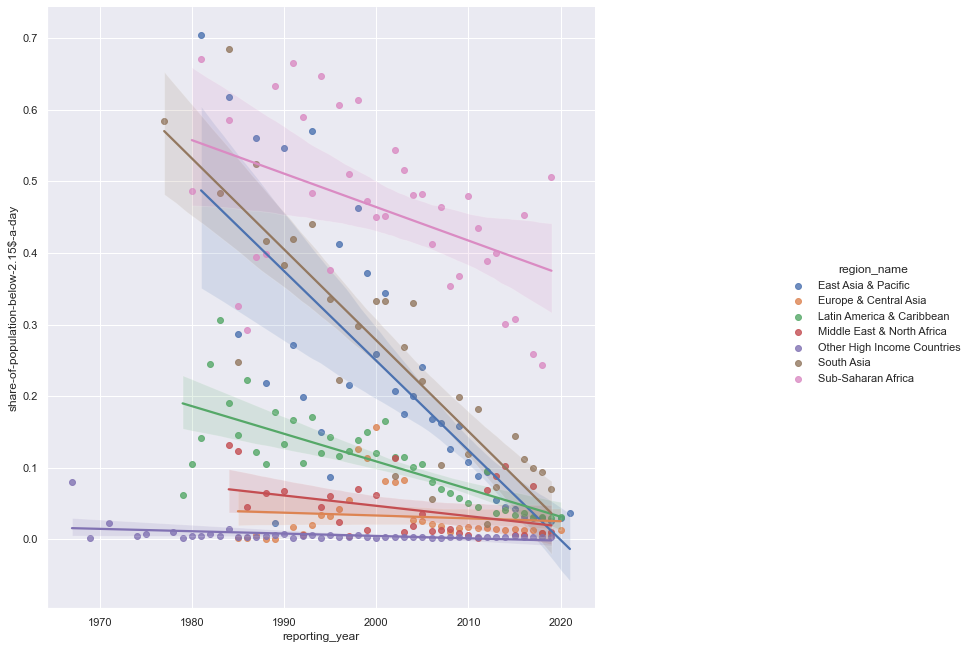

In [94]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# Grouping by region and year
df_gp = df.groupby(['region_name', 'reporting_year']).mean()
df_gp.reset_index(inplace=True)

# Plot the responses for different events and regions
# sns.set(rc={'figure.figsize':(30,20)})
g = sns.lmplot(x="reporting_year", y="share-of-population-below-2.15$-a-day",
             hue="region_name", data=df_gp)
g.figure.set_size_inches(15, 10)

In [97]:

df_le

,Entity,Code,Year,Life expectancy at birth (historical)
0,Afghanistan,AFG,1950,27.7
1,Afghanistan,AFG,1951,28.0
2,Afghanistan,AFG,1952,28.4
3,Afghanistan,AFG,1953,28.9
4,Afghanistan,AFG,1954,29.2
...,...,...,...,...
20440,Zimbabwe,ZWE,2017,60.7
20441,Zimbabwe,ZWE,2018,61.4
20442,Zimbabwe,ZWE,2019,61.3
20443,Zimbabwe,ZWE,2020,61.1


In [105]:
df_le.rename(columns={'Entity': 'country_name', 'Code':'country_code', 'Year':'reporting_year'}, inplace=True)

In [109]:
df = df.merge(df_le, on=['country_name', 'country_code', 'reporting_year'], how='outer', copy=False)

In [112]:
df.merge()

,region_name,region_code,country_name,country_code,reporting_year,share-of-population-below-2.15$-a-day,Life expectancy at birth (historical)
0,Sub-Saharan Africa,SSA,Angola,AGO,2000,0.214088,46.0
1,Sub-Saharan Africa,SSA,Angola,AGO,2008,0.146325,54.6
2,Sub-Saharan Africa,SSA,Angola,AGO,2018,0.311220,62.1
3,Europe & Central Asia,ECA,Albania,ALB,1996,0.005348,74.6
4,Europe & Central Asia,ECA,Albania,ALB,2002,0.010926,75.9
...,...,...,...,...,...,...,...
20846,NaN,NaN,Zimbabwe,ZWE,2015,NaN,59.6
20847,NaN,NaN,Zimbabwe,ZWE,2016,NaN,60.3
20848,NaN,NaN,Zimbabwe,ZWE,2018,NaN,61.4
20849,NaN,NaN,Zimbabwe,ZWE,2020,NaN,61.1


In [116]:
pd.merge(df, df_region_country, on='country_name', how='left')

,region_name_x,region_code_x,country_name,country_code_x,reporting_year,share-of-population-below-2.15$-a-day,Life expectancy at birth (historical),region_name_y,region_code_y,country_code_y
0,Sub-Saharan Africa,SSA,Angola,AGO,2000,0.214088,46.0,Sub-Saharan Africa,SSA,AGO
1,Sub-Saharan Africa,SSA,Angola,AGO,2008,0.146325,54.6,Sub-Saharan Africa,SSA,AGO
2,Sub-Saharan Africa,SSA,Angola,AGO,2018,0.311220,62.1,Sub-Saharan Africa,SSA,AGO
3,Europe & Central Asia,ECA,Albania,ALB,1996,0.005348,74.6,Europe & Central Asia,ECA,ALB
4,Europe & Central Asia,ECA,Albania,ALB,2002,0.010926,75.9,Europe & Central Asia,ECA,ALB
...,...,...,...,...,...,...,...,...,...,...
20846,NaN,NaN,Zimbabwe,ZWE,2015,NaN,59.6,Sub-Saharan Africa,SSA,ZWE
20847,NaN,NaN,Zimbabwe,ZWE,2016,NaN,60.3,Sub-Saharan Africa,SSA,ZWE
20848,NaN,NaN,Zimbabwe,ZWE,2018,NaN,61.4,Sub-Saharan Africa,SSA,ZWE
20849,NaN,NaN,Zimbabwe,ZWE,2020,NaN,61.1,Sub-Saharan Africa,SSA,ZWE


In [104]:
df_le

,Entity,Code,Year,Life expectancy at birth (historical)
0,Afghanistan,AFG,1950,27.7
1,Afghanistan,AFG,1951,28.0
2,Afghanistan,AFG,1952,28.4
3,Afghanistan,AFG,1953,28.9
4,Afghanistan,AFG,1954,29.2
...,...,...,...,...
20440,Zimbabwe,ZWE,2017,60.7
20441,Zimbabwe,ZWE,2018,61.4
20442,Zimbabwe,ZWE,2019,61.3
20443,Zimbabwe,ZWE,2020,61.1


In [115]:
df_region_country.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 0 to 2206
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   region_name   169 non-null    object
 1   region_code   169 non-null    object
 2   country_name  169 non-null    object
 3   country_code  169 non-null    object
dtypes: object(4)
memory usage: 6.6+ KB


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20851 entries, 0 to 20850
Data columns (total 7 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   region_name                            2209 non-null   object 
 1   region_code                            2209 non-null   object 
 2   country_name                           20851 non-null  object 
 3   country_code                           19464 non-null  object 
 4   reporting_year                         20851 non-null  int64  
 5   share-of-population-below-2.15$-a-day  2209 non-null   float64
 6   Life expectancy at birth (historical)  20631 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.3+ MB
